# Distributional impact within groups



Modeled after [Anderson Frailey's notebook](http://nbviewer.jupyter.org/github/andersonfrailey/Notebook-Uploads/blob/master/Visualizing%20the%20TCJA.ipynb) using Bokeh, which was in turn modeled after [Jonathan Schwabish's piece for Urban](https://www.urban.org/urban-wire/how-we-can-better-visualize-analysis-tax-reform-legislation).

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# On Python 3.6 use "import urllib.request as url_lib".
import urllib as url_lib

In [2]:
tc.__version__

'0.18.0'

### 2017 law

In [3]:
BASE_URL = ('https://raw.githubusercontent.com/' +
            'open-source-economics/Tax-Calculator/master/taxcalc/reforms/')
y2017_name = '2017_law.json'
y2017_text = url_lib.urlopen(BASE_URL + y2017_name).read()
y2017_reform = tc.Calculator.read_json_param_objects(y2017_text, None)

### Settings

In [4]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [5]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [6]:
# Number of decimals when printing pandas DataFrames.
pd.set_option('precision', 2)

### Utilities

In [7]:
def weight(df, col):
    return df[col] * df.s006

def weighted_sum(df, col):
    return weight(df, col).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

## Generate data

In [8]:
recs = tc.Records.cps_constructor()
pol = tc.Policy()
calc_tcja = tc.Calculator(records=recs, policy=pol, verbose=False)
calc_tcja.advance_to_year(2018)
calc_tcja.calc_all()

pol.implement_reform(y2017_reform['policy'])
calc_base = tc.Calculator(records=recs, policy=pol, verbose=False)
calc_base.advance_to_year(2018)
calc_base.calc_all()

In [9]:
base = calc_base.dataframe(['RECID', 'aftertax_income', 's006', 'XTOT'])
base.rename(columns={'aftertax_income': 'afti_base'}, inplace=True)
tcja = calc_tcja.dataframe(['RECID', 'aftertax_income'])
tcja.rename(columns={'aftertax_income': 'afti_tcja'}, inplace=True)

In [10]:
tu = pd.merge(base, tcja, on='RECID').drop(columns='RECID')

## Preprocess

In [11]:
tu['afti_base_bin'] = (
    pd.cut(tu.afti_base.astype('int'),
           pd.Series([0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 1000, np.inf])
           * 1000,
           labels=['Less than \$10K', '\$10K to \$20K', '\$20K to \$30K', 
                   '\$30K to \$40K', '\$40K to \$50K', '\$50K to \$75K', 
                   '\$75K to \$100K', '\$100K to \$200K', '\$200K to \$500K', 
                   '\$500K to \$1M', '\$1M or more']))

In [12]:
tu['tax_chg_bin'] = pd.cut(
    tu.afti_base - tu.afti_tcja, 
    [-np.inf, -500, -100, 100, 500, np.inf],
    labels=['Decrease greater than \$500', 'Decrease \$100 to \$500',
            'Less than \$100 change', 'Increase greater than \$500', 
            'Increase \$100 to \$500'])

In [13]:
pivot = tu.pivot_table(index='afti_base_bin', columns='tax_chg_bin', 
                       values='s006', aggfunc=sum)
pivot = pivot.div(pivot.sum(axis=1), axis=0)

In [14]:
COLORS = ['#004ba0',  # Dark blue.
          '#63a4ff',  # Light blue.
          '#bdbdbd',  # Gray.
          '#ffe54c',  # Light amber.
          '#ffb300']  # Medium amber.

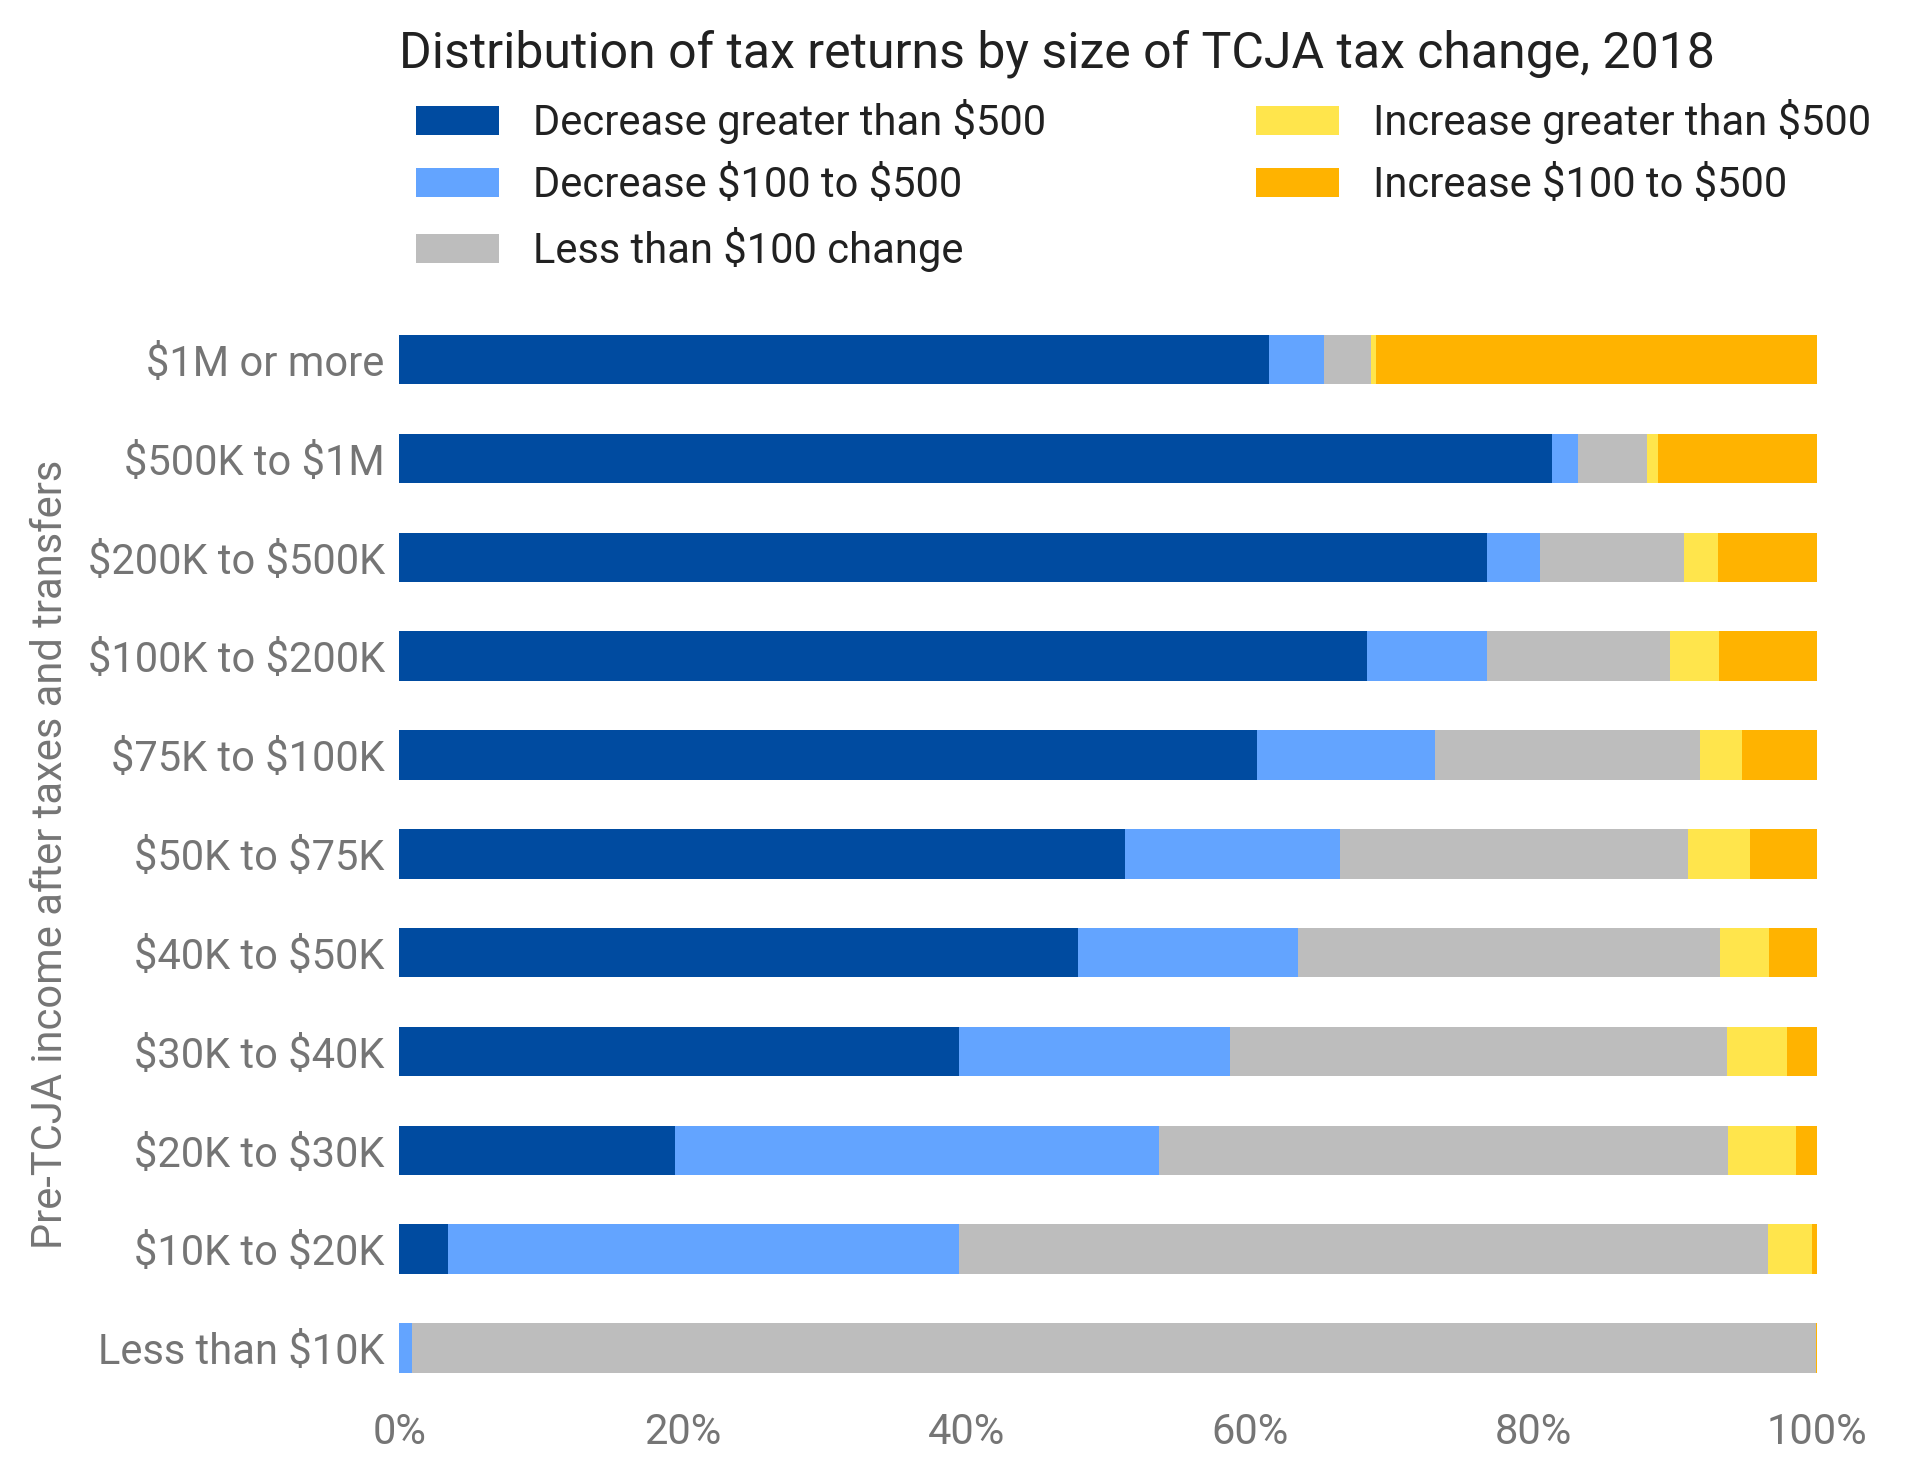

In [15]:
ax = pivot.plot.barh(stacked=True, color=COLORS)
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                    ncol=2, mode="expand", borderaxespad=0.)
# https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
plt.setp(legend.get_title(), fontsize=6)  # Not working.
sns.despine(left=True, bottom=True)
ax.set(xlabel='', ylabel='Pre-TCJA income after taxes and transfers')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Distribution of tax returns by size of TCJA tax change, 2018', 
          loc='left', y=1.2)
plt.show()